## Import libraries

In [1]:
# Import libraries
import torch
import torchvision
import cv2
import glob
import xml.etree.ElementTree as ET
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from torchvision import models
from torchvision import transforms
from PIL import Image

In [2]:
# to save kernel from dying
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Data exploration

### Define CustomDataset class

This CustomDataset class is designed for loading images and their corresponding annotations in a way compatible with PyTorch’s Dataset class. It’s meant for training an object detection model where each image has bounding box annotations (typically in XML format). <br>
The CustomDataset class will:
* Load each image and convert it to a tensor.
* Parse the corresponding annotation XML files, extracting bounding boxes and labels.
* Prepare this data in a format suitable for training an object detection model.

In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, annotation_paths):
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        annotation_path = self.annotation_paths[idx]
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = F.to_tensor(img)  # Convert to tensor
        
        # Parse annotation
        target = self.parse_annotation(annotation_path)
        
        return img, target

    def __len__(self):
        return len(self.image_paths)

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []
        
        for obj in root.findall('object'):
            # Extract label first label = obj.find('name').text
            label = obj.find('name').text
            
            if label == 'person':
                label = 1
            elif label == 'tag':
                label = 2
            else:
                label = 0  # 'background' or any other irrelevant label

            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])  # Store each bounding box
            labels.append(label)  # Store each label

        # Ensure there are bounding boxes
        assert len(boxes) > 0, f"No bounding boxes found in annotation: {annotation_path}"

        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)  # Shape: [N, 4]
        labels = torch.tensor(labels, dtype=torch.int64)  # Shape: [N]

        return {
            'boxes': boxes,
            'labels': labels
        }

### Load training dataset

This following code loads a dataset for training by preparing the images and corresponding annotations, then creating a data loader to manage how batches of data are accessed during training.
* `glob.glob`: Finds all file paths that match a specified pattern
* The images and annotations are loaded and formatted as defined in `CustomDataset`

In [4]:
# Load your dataset
train_image_paths = glob.glob(r"C:\Users\ruyit\Pictures\output4\*.png")
train_annotation_paths = glob.glob(r"C:\Users\ruyit\Pictures\output4_bbox\*.xml")

train_dataset = CustomDataset(train_image_paths, train_annotation_paths)

#### Check number of images and annotations

The following code check the number of images and annotations <br>
**Note:** Faster R-CNN expects a pair of image and annotation during training. 

In [5]:
print(len(train_image_paths))
print(len(train_annotation_paths))

85
85


#### Check a sample from training dataset

The following code is designed to manually inspect an example from the custom dataset to ensure the dataset is loading images and annotations correctly. Manually inspecting the data at this stage is important because it helps verify that the dataset class is functioning as expected, with the image and annotations in the correct format for training. (to catch potential issues early, reducing debugging time)
<br><br>
**Note:**<br>
The expected shape for image tensor is [C, H, W], where:
* C is the number of channels (e.g., 3 for RGB images)
* H is the height of the image
* W is the width of the image

In [6]:
# Manually inspect an example
img, target = train_dataset[0]  # Load the first image and its annotation

print("Image shape:", img.shape)  # Should be in the shape [C, H, W]
print("Target:", target)  # Should be a dictionary with 'boxes' and 'labels'

# Check the boxes and labels directly
print("Bounding boxes:", target['boxes'])
print("Labels:", target['labels'])

Image shape: torch.Size([3, 720, 960])
Target: {'boxes': tensor([[ 48., 425., 156., 498.],
        [ 87., 441., 104., 459.]]), 'labels': tensor([1, 2])}
Bounding boxes: tensor([[ 48., 425., 156., 498.],
        [ 87., 441., 104., 459.]])
Labels: tensor([1, 2])


### Visualize an image

Visualize the an image with labels and bounding boxes

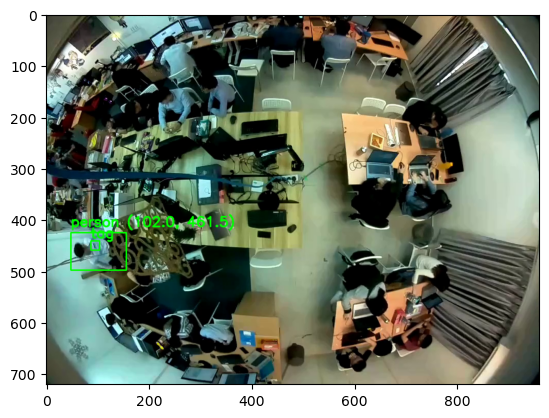

In [17]:
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Example path to images and XML files
image_path = r"C:\Users\ruyit\Pictures\output4\frame.c_106.png"
xml_path = r"C:\Users\ruyit\Pictures\output4_bbox\frame.c_106.xml"

# Read image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format for displaying

# Parse XML
tree = ET.parse(xml_path)
root = tree.getroot()

# Loop over each 'object' in the XML file
for obj in root.findall('object'):
    # Extract the label (name of the object)
    label = obj.find('name').text
    
    # Extract the bounding box coordinates for each object
    bbox = obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)
    
    # Draw bounding box on the image: cv2.rectangle(image, start_point, end_point, color, thickness)  
    image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    # Display coordinate and label if label == "person"
    if label == "person":
        # Calculate the midpoint of the bounding 
        midpoint_x = (xmin + xmax) / 2
        midpoint_y = (ymin + ymax) / 2

        # Display the label text above the bounding box
        # cv2.putText(image, text, coordinate of text, font, fontScale, color, thickness, lineType)
        image = cv2.putText(image, f"{label} ({midpoint_x}, {midpoint_y})", (xmin, ymin - 12), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)
        
    # Display label only if label == "tag"
    if label == "tag":
        # Display the label text above the bounding box
        # cv2.putText(image, text, coordinate of text, font, fontScale, color, thickness, lineType)
        image = cv2.putText(image, label, (xmin, ymin - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)

# Display the image with bounding boxes, labels, and midpoints using matplotlib
plt.imshow(image)
plt.axis('on')  # Hide axes
plt.show()

## Model Customization and Training

### Load pretrained Faster R-CNN model

**Faster R-CNN model** is chosen as it is **effective in detecting objects with complex shapes and small objects**. It's two-stage approach allows it to achieve high accuracy and precision in object detection, especially for **complex and cluttered scenes** 

The following code loads a pretrained Faster R-CNN model, sets it to evaluation mode, and freezes the backbone layers (ResNet) to prevent them from updating during training. <br>

**Note:** When training a model, you typically set it to training mode `(model.train())`. However, setting the model to evaluation mode `(model.eval())` before freezing the backbone layers ensures that batch normalization layers and dropout layers behave correctly while you're freezing these layers.

In [8]:
# Load the model with the latest weights argument
weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1 
# The above specifies the COCO dataset weights (equivalent to pretrained=True)
model = fasterrcnn_resnet50_fpn(weights=weights) 
model.eval()  # Set model to evaluation mode

# Freeze the backbone layers (ResNet)
for param in model.backbone.parameters():
    param.requires_grad = False

### Model customization

The following code will display the default for the FastRCNNPredictor layer when using Faster R-CNN with COCO dataset weights (COCO_V1).

In [9]:
# Inspect the model's predictor
print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)


Modifying the Faster R-CNN model to match the number of classes in the dataset (which is 3: 'person', 'tag', and 'background')

In [10]:
# Modify the model to match the number of classes in your dataset
num_classes = 3  # 'person', 'tag' and 'background' (the background is usually class 0)

# Get the input dimension of the box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the classifier with a new one (for your number of classes)
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Unfreeze the last layers (this will train the final layers)
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

Check the preditor again to ensure the predictors are updated

In [11]:
# Inspect the model to ensure the predictor has been updated
print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=3, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
)


#### Optimizer setup

This `params` line ensures that only the trainable parameters are considered by the optimizer, making training faster and more memory-efficient. <br>

Some parameters, like those of the backbone (if it’s frozen), do not require gradients and should not be updated during training. By filtering these out, you ensure only the relevant parameters are updated. <br>

The `optimizer` is responsible for updating the parameters of the model based on the computed gradients. Adam is chosen for its efficiency and effectiveness in many deep learning tasks.<br>

**Note:** 
Learning Rate: <br>
The learning rate (lr) controls how much to adjust the model’s parameters with respect to the loss gradient. A higher learning rate can speed up training but may overshoot the optimal solution, while a lower learning rate ensures more precise adjustments.

In [12]:
params = [p for p in model.parameters() if p.requires_grad]  # Get only the parameters that require gradients
optimizer = optim.Adam(params, lr=0.005)

#### Data loading and batching with a custom collate function

The provided code defines a collate_fn function and uses it in a DataLoader to manage how batches are created from a custom dataset

* `DataLoader`: Creates an iterable loader for the dataset. It’s responsible for:
    * Dividing the dataset into batches (batch_size=4), which makes it more efficient for training.
    * Shuffling the dataset (shuffle=True), which helps prevent the model from learning the data order, aiding generalization.
    * Each batch will contain:
        * Four image tensors
        * Corresponding labels and bounding boxes for objects in each image
          
**Note:**
* Generalization: Smaller batch sizes often introduce more "noise" during training, which can help models generalize better on unseen data. This randomness can act as a form of regularization, helping the model avoid overfitting.
* Gradient Stability: Larger batch sizes provide more stable gradients, which can lead to faster convergence. However, very large batch sizes may result in poor generalization because the model might converge to a sharp local minimum.

In [13]:
def collate_fn(batch):
    images = []
    targets = []
    for sample in batch:
        images.append(sample[0])
        targets.append(sample[1])

    return images, targets

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

### Model training

In [14]:
# Define the number of epochs
num_epochs = 10

# Move model to the appropriate device (GPU if available, otherwise CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        loss_dict = model(images, targets)
        
        # Compute total loss
        losses = sum(loss for loss in loss_dict.values())
        
        # Backpropagation
        losses.backward()
        
        # Update the model weights
        optimizer.step()
        
        running_loss += losses.item()

    print(f"Epoch #{epoch+1} Loss: {running_loss / len(train_loader)}")

Epoch #1 Loss: 0.7478080100633882
Epoch #2 Loss: 0.19925229386849838
Epoch #3 Loss: 0.1829087876460769
Epoch #4 Loss: 0.16571614823558115
Epoch #5 Loss: 0.1603933017362248
Epoch #6 Loss: 0.16199083558537744
Epoch #7 Loss: 0.14447900957681917
Epoch #8 Loss: 0.13988895206288857
Epoch #9 Loss: 0.1338845884258097
Epoch #10 Loss: 0.12919474426995625


#### Save the model
The `state_dict` is a Python dictionary object that maps each layer to its parameter tensor. In simpler terms, it contains all the weights and biases of the model. By saving the state_dict, you ensure that the model's learned parameters are stored and can be reloaded later.

In [15]:
# Save the model
torch.save(model.state_dict(), 'model.pth')